<a href="https://colab.research.google.com/github/sunyingjian/-Logging-related-network/blob/master/%E5%BB%B6%E5%AE%89%E6%B2%B9%E7%94%B0%E5%86%B3%E7%AD%96%E6%A0%91.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### <font size=5px color="red">✦ *Google Colab 突破90分钟自动断开:</font>
<p><font size=3px > 每60分钟自动运行代码以刷新90分钟断开限制. 打开 developer-settings (在你的浏览器) 快速健 Ctrl+Shift+I 然后按console 输入以下代码 Enter. ( mac 按 Option+Command+I)</p><b>复制以下隐藏代码粉贴在浏览器console！！不要关闭浏览器以免失效</b>

<code>function ClickConnect(){
console.log("Working"); 
document.querySelector("colab-connect-button").click() 
}setInterval(ClickConnect,6000)</code>

In [ ]:
#@markdown <h3>← 输入了代码后运行以防止断开</h>


import IPython
from google.colab import output

display(IPython.display.Javascript('''
 function ClickConnect(){
   btn = document.querySelector("colab-connect-button")
   if (btn != null){
     console.log("Click colab-connect-button"); 
     btn.click() 
     }
   
   btn = document.getElementById('ok')
   if (btn != null){
     console.log("Click reconnect"); 
     btn.click() 
     }
  }
  
setInterval(ClickConnect,60000)
'''))

print("Done.")

<IPython.core.display.Javascript object>

Done.


# Facies classification using Machine Learning

#### Brendon Hall, [Enthought](https://www.enthought.com/)

This notebook demonstrates how to train a machine learning algorithm to predict facies from well log data.  The dataset we will use comes from a class excercise from The University of Kansas on [Neural Networks and Fuzzy Systems](http://www.people.ku.edu/~gbohling/EECS833/).  This exercise is based on a consortium project to use machine learning techniques to create a reservoir model of the largest gas fields in North America, the Hugoton and Panoma Fields. For more info on the origin of the data, see [Bohling and Dubois (2003)](http://www.kgs.ku.edu/PRS/publication/2003/ofr2003-50.pdf) and [Dubois et al. (2007)](http://dx.doi.org/10.1016/j.cageo.2006.08.011). 

The dataset we will use is log data from nine wells that have been labeled with a facies type based on oberservation of core.  We will use this log data to train a support vector machine to classify facies types.  Support vector machines (or SVMs) are a type of supervised learning model that can be trained on data to perform classification and regression tasks.  The SVM algorithm uses the training data to fit an optimal hyperplane between the different classes (or facies, in our case).  We will use the SVM implementation in [scikit-learn](http://scikit-learn.org/stable/modules/svm.html).

First we will [explore the dataset](#Exploring-the-dataset).  We will load the training data from 9 wells, and take a look at what we have to work with.  We will plot the data from a couple wells, and create cross plots to look at the variation within the data.  

Next we will [condition the data set](#Conditioning-the-data-set).  We will remove the entries that have incomplete data.  The data will be scaled to have zero mean and unit variance.  We will also split the data into training and test sets.

We will then be ready to [build the SVM classifier](#Building-the-SVM-classifier).  We will demonstrate how to use the cross validation set to do [model parameter selection](#Model-parameter-selection).

Finally, once we have a built and tuned the classifier, we can [apply the trained model](#Applying-the-classification-model-to-new-data) to classify facies in wells which do not already have labels.  We will apply the classifier to two wells, but in principle you could apply the classifier to any number of wells that had the same log data.

## Exploring the dataset

First, we will examine the data set we will use to train the classifier.  The training data is contained in the file `facies_vectors.csv`.  The dataset consists of 5 wireline log measurements, two indicator variables and a facies label at half foot intervals.  In machine learning terminology, each log measurement is a feature vector that maps a set of 'features' (the log measurements) to a class (the facies type).  We will use the pandas library to load the data into a dataframe, which provides a convenient data structure to work with well log data.

In [ ]:
!git clone https://github.com/seg/tutorials-2016.git
! git clone https://github.com/sunyingjian/Machine-Learning-From-Scratch.git

Cloning into 'tutorials-2016'...
remote: Enumerating objects: 161, done.
remote: Total 161 (delta 0), reused 0 (delta 0), pack-reused 161
Receiving objects: 100% (161/161), 16.86 MiB | 25.47 MiB/s, done.
Resolving deltas: 100% (64/64), done.
Cloning into 'Machine-Learning-From-Scratch'...
remote: Enumerating objects: 287, done.
remote: Total 287 (delta 0), reused 0 (delta 0), pack-reused 287
Receiving objects: 100% (287/287), 91.24 KiB | 3.65 MiB/s, done.
Resolving deltas: 100% (133/133), done.


In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/Facies_classification"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
%matplotlib inline
#%matplotlib inline 可以在Ipython编译器里直接使用，功能是可以内嵌绘图，并且可以省略掉plt.show()这一步。
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pandas import set_option
set_option("display.max_rows", 10)#设置要显示的默认行数，显示的最大行数是10
pd.options.mode.chained_assignment = None #为了在增加列表行数的时候防止出现setting with copy warning
filename = 'facies_vectors.csv'
training_data = pd.read_csv('/content/tutorials-2016/1610_Facies_classification/training_data.csv')
training_data

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.450,0.664,9.900,11.915,4.600,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.260,0.661,14.200,12.565,4.100,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.050,0.658,14.800,13.050,3.600,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.100,0.655,13.900,13.115,3.500,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.580,0.647,13.500,13.300,3.400,1,0.915
...,...,...,...,...,...,...,...,...,...,...,...
3227,5,C LM,CHURCHMAN BIBLE,3120.5,46.719,0.947,1.828,7.254,3.617,2,0.685
3228,5,C LM,CHURCHMAN BIBLE,3121.0,44.563,0.953,2.241,8.013,3.344,2,0.677
3229,5,C LM,CHURCHMAN BIBLE,3121.5,49.719,0.964,2.925,8.013,3.190,2,0.669
3230,5,C LM,CHURCHMAN BIBLE,3122.0,51.469,0.965,3.083,7.708,3.152,2,0.661


Remove a single well to use as a blind test later.

In [ ]:
blind = training_data[training_data['Well Name'] == 'SHANKLE']
#抽出一部分作为验证集
training_data = training_data[training_data['Well Name'] != 'SHANKLE']

This data is from the Council Grove gas reservoir in Southwest Kansas.  The Panoma Council Grove Field is predominantly a carbonate gas reservoir encompassing 2700 square miles in Southwestern Kansas.  This dataset is from nine wells (with 4149 examples), consisting of a set of seven predictor variables and a rock facies (class) for each example vector and validation (test) data (830 examples from two wells) having the same seven predictor variables in the feature vector.  Facies are based on examination of cores from nine wells taken vertically at half-foot intervals. Predictor variables include five from wireline log measurements and two geologic constraining variables that are derived from geologic knowledge. These are essentially continuous variables sampled at a half-foot sample rate. 

The seven predictor variables are:
* Five wire line log curves include [gamma ray](http://petrowiki.org/Gamma_ray_logs) (GR), [resistivity logging](http://petrowiki.org/Resistivity_and_spontaneous_%28SP%29_logging) (ILD_log10),
[photoelectric effect](http://www.glossary.oilfield.slb.com/en/Terms/p/photoelectric_effect.aspx) (PE), [neutron-density porosity difference and average neutron-density porosity](http://petrowiki.org/Neutron_porosity_logs) (DeltaPHI and PHIND). Note, some wells do not have PE.
* Two geologic constraining variables: nonmarine-marine indicator (NM_M) and relative position (RELPOS)

The nine discrete facies (classes of rocks) are: 
1. Nonmarine sandstone
2. Nonmarine coarse siltstone 
3. Nonmarine fine siltstone 
4. Marine siltstone and shale 
5. Mudstone (limestone)
6. Wackestone (limestone)
7. Dolomite
8. Packstone-grainstone (limestone)
9. Phylloid-algal bafflestone (limestone)

These facies aren't discrete, and gradually blend into one another. Some have neighboring facies that are rather close.  Mislabeling within these neighboring facies can be expected to occur.  The following table lists the facies, their abbreviated labels and their approximate neighbors.

这里说的是相邻相的问题

Facies |Label| Adjacent Facies
:---: | :---: |:--:
1 |SS| 2
2 |CSiS| 1,3
3 |FSiS| 2
4 |SiSh| 5
5 |MS| 4,6
6 |WS| 5,7
7 |D| 6,8
8 |PS| 6,7,9
9 |BS| 7,8

Let's clean up this dataset.  The 'Well Name' and 'Formation' columns can be turned into a categorical data type.  

In [ ]:
training_data['Well Name'] = training_data['Well Name'].astype('category')
training_data['Formation'] = training_data['Formation'].astype('category')
training_data['Well Name'].unique()

[SHRIMPLIN, LUKE G U, CROSS H CATTLE, NOLAN, Recruit F9, NEWBY, CHURCHMAN BIBLE]
Categories (7, object): [SHRIMPLIN, LUKE G U, CROSS H CATTLE, NOLAN, Recruit F9, NEWBY,
                         CHURCHMAN BIBLE]

These are the names of the 10 training wells in the Council Grove reservoir.  Data has been recruited into pseudo-well 'Recruit F9' to better represent facies 9, the Phylloid-algal bafflestone. 

Before we plot the well data, let's define a color map so the facies are represented by consistent color in all the plots in this tutorial.  We also create the abbreviated facies labels, and add those to the `facies_vectors` dataframe.

In [ ]:
# 1=sandstone  2=c_siltstone   3=f_siltstone 
# 4=marine_silt_shale 5=mudstone 6=wackestone 7=dolomite
# 8=packstone 9=bafflestone
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00',
       '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS',
                 'WS', 'D','PS', 'BS']
#facies_color_map is a dictionary that maps facies labels
#to their respective colors
facies_color_map = {}
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]

def label_facies(row, labels):
    return labels[ row['Facies'] -1]
    
training_data.loc[:,'FaciesLabels'] = training_data.apply(lambda row: label_facies(row, facies_labels), axis=1) #建立标签
training_data.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,2783.000000,2783.000000,2783.000000,2783.000000,2783.000000,2783.000000,2783.000000,2783.000000,2783.000000
mean,4.558390,2873.456522,66.249445,0.644637,3.754963,13.118929,3.805693,1.523895,0.523057
std,2.515249,138.349383,31.610849,0.241922,5.045916,7.389665,0.894118,0.499518,0.287499
min,1.000000,2573.500000,13.250000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.010000
25%,2.000000,2767.500000,46.081500,0.497000,1.300000,8.165000,3.200000,1.000000,0.276500
50%,4.000000,2895.000000,65.541000,0.627000,3.581000,11.900000,3.600000,2.000000,0.529000
75%,7.000000,2987.000000,80.714000,0.812323,6.500000,16.144000,4.400000,2.000000,0.771500
max,9.000000,3122.500000,361.150000,1.480000,18.500000,84.400000,8.094000,2.000000,1.000000


This is a quick view of the statistical distribution of the input variables.  Looking at the `count` values, most values have 4149 valid values except for `PE`, which has 3232.  In this tutorial we will drop the feature vectors that don't have a valid `PE` entry.

In [ ]:
PE_mask = training_data['PE'].notnull().values
training_data = training_data[PE_mask]

Let's take a look at the data from individual wells in a more familiar log plot form.  We will create plots for the five well log variables, as well as a log for facies labels.  The plots are based on the those described in Alessandro Amato del Monte's [excellent tutorial](https://github.com/seg/tutorials/tree/master/1504_Seismic_petrophysics_1).

In [ ]:
def make_facies_log_plot(logs, facies_colors):
    #确认测井数据是以深度排序的
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster=np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=6, figsize=(8, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im=ax[5].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[5])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

Placing the log plotting code in a function will make it easy to plot the logs from multiples wells, and can be reused later to view the results when we apply the facies classification model to other wells.  The function was written to take a list of colors and facies labels as parameters.  

We then show log plots for wells `SHRIMPLIN`.  

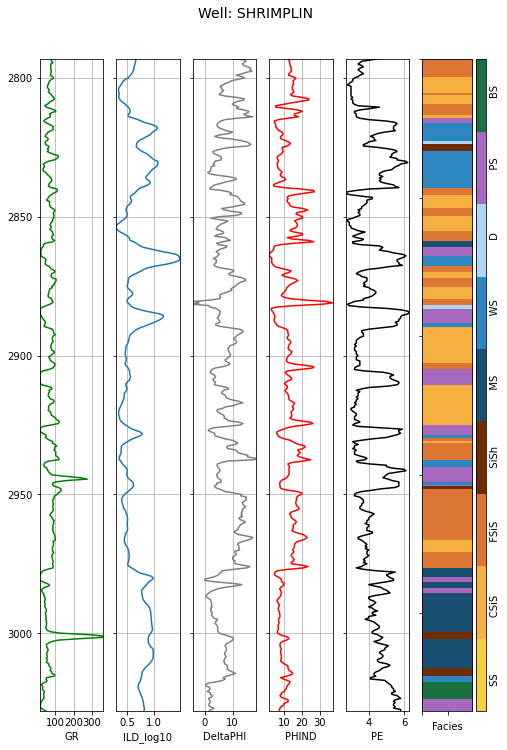

In [ ]:
make_facies_log_plot(
    training_data[training_data['Well Name'] == 'SHRIMPLIN'],
    facies_colors)

In addition to individual wells, we can look at how the various facies are represented by the entire training set.  Let's plot a histgram of the number of training examples for each facies class.

SS      170
CSiS    649
FSiS    498
SiSh    177
MS      198
WS      391
D        81
PS      458
BS      161
Name: Facies, dtype: int64

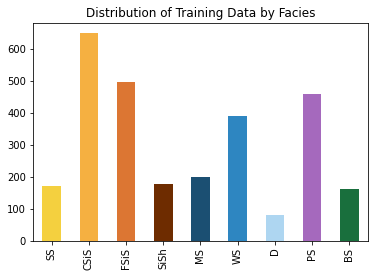

In [ ]:
#count the number of unique entries for each facies, sort them by facies number (instead of by number of entries)
#计算每个相的唯一条目数，然后按相数（而不是条目数）对它们进行排序
facies_counts = training_data['Facies'].value_counts().sort_index()
#use facies labels to index each count
#使用相标签索引每个计数
facies_counts.index = facies_labels

facies_counts.plot(kind='bar',color=facies_colors, 
                   title='Distribution of Training Data by Facies')
facies_counts

This shows the distribution of examples by facies for the 3232 training examples in the training set.  Dolomite (facies 7) has the fewest with 141 examples.  There are also only 185 bafflestone examples.  Depending on the performance of the classifier we are going to train, we may consider getting more examples of these facies.

这显示了训练集中3232个训练实例的相分布。白云岩(相7)最少，有141个实例。也只有185个莫名其妙的例子。根据我们要训练的分类器的性能，我们可以考虑获得更多的这些相的例子。



Crossplots are a familiar tool in the geosciences to visualize how two properties vary with rock type.  This dataset contains 5 log variables, and scatter matrix can help to quickly visualize the variation between the all the variables in the dataset.  We can employ the very useful [Seaborn library](https://stanford.edu/~mwaskom/software/seaborn/) to quickly create a nice looking scatter matrix. Each pane in the plot shows the relationship between two of the variables on the x and y axis, with each point is colored according to its facies.  The same colormap is used to represent the 9 facies.  

交会图是地球科学中常见的一种工具，它可以直观地描述两种属性随岩石类型的变化。该数据集包含5个日志变量，散点矩阵可以帮助快速可视化数据集中所有变量之间的变化。我们可以使用非常有用的Seaborn库来快速创建一个漂亮的分散矩阵。图中的每个窗格显示x轴和y轴上的两个变量之间的关系，每个点根据其相进行着色。相同的颜色图用于表示9相。

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The datapath rcparam was deprecated in Matplotlib 3.2.1 and will be removed two minor releases later.
  self[key] = other[key]
/usr/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/usr/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/

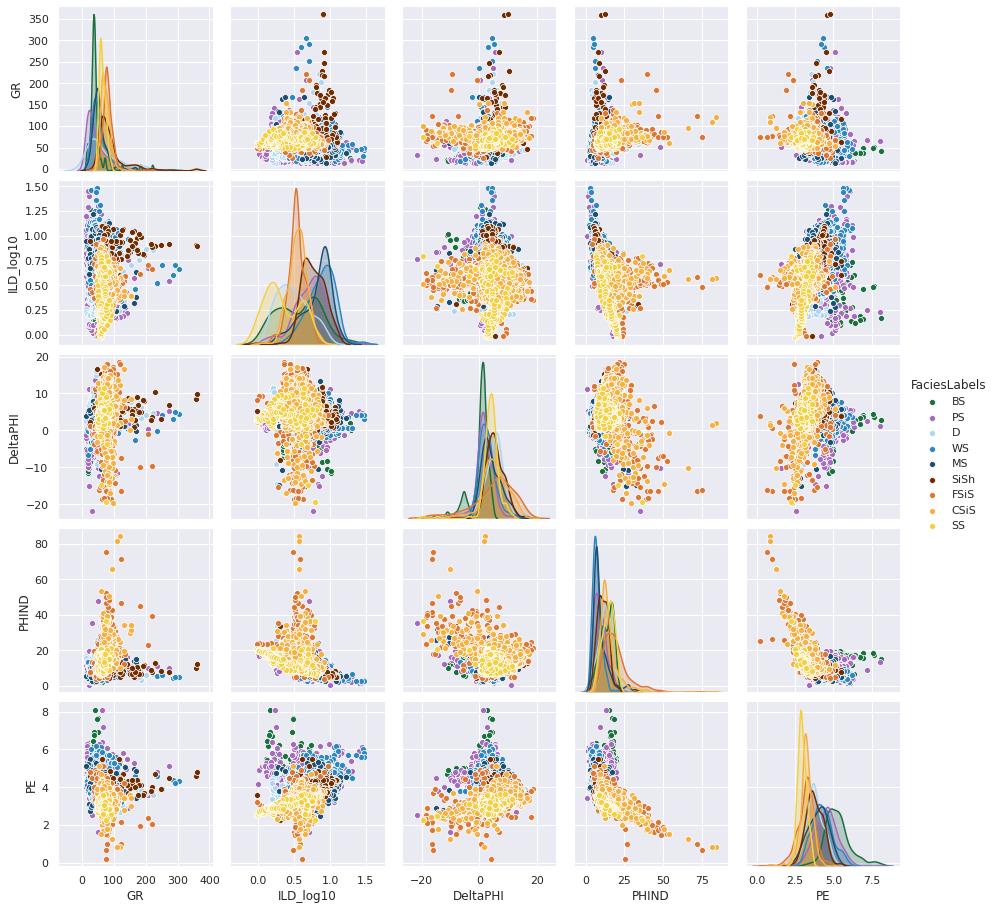

In [ ]:
#save plot display settings to change back to when done plotting with seaborn
inline_rc = dict(mpl.rcParams)

import seaborn as sns
sns.set()
sns.pairplot(training_data.drop(['Well Name','Facies','Formation','Depth','NM_M','RELPOS'],axis=1),
             hue='FaciesLabels', palette=facies_color_map,
             hue_order=list(reversed(facies_labels)))

#switch back to default matplotlib plot style
mpl.rcParams.update(inline_rc)

## Conditioning the data set

Now we extract just the feature variables we need to perform the classification.  The predictor variables are the five wireline values and two geologic constraining variables. We also get a vector of the facies labels that correspond to each feature vector.

现在，我们仅提取执行分类所需的特征变量。 预测变量是五个有线值和两个地质约束变量。 我们还获得了与每个特征向量相对应的相标签向量。

In [ ]:
correct_facies_labels = training_data['Facies'].values

feature_vectors = training_data.drop(['Formation', 'Well Name', 'Depth','Facies','FaciesLabels'], axis=1)
feature_vectors.describe()

,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,2783.000000,2783.000000,2783.000000,2783.000000,2783.000000,2783.000000,2783.000000
mean,66.249445,0.644637,3.754963,13.118929,3.805693,1.523895,0.523057
std,31.610849,0.241922,5.045916,7.389665,0.894118,0.499518,0.287499
min,13.250000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.010000
25%,46.081500,0.497000,1.300000,8.165000,3.200000,1.000000,0.276500
50%,65.541000,0.627000,3.581000,11.900000,3.600000,2.000000,0.529000
75%,80.714000,0.812323,6.500000,16.144000,4.400000,2.000000,0.771500
max,361.150000,1.480000,18.500000,84.400000,8.094000,2.000000,1.000000


Scikit includes a [preprocessing](http://scikit-learn.org/stable/modules/preprocessing.html) module that can 'standardize' the data (giving each variable zero mean and unit variance, also called *whitening*).  Many machine learning algorithms assume features will be standard normally distributed data (ie: Gaussian with zero mean and unit variance).  The factors used to standardize the training set must be applied to any subsequent feature set that will be input to the classifier.  The `StandardScalar` class can be fit to the training set, and later used to standardize any training data.

Scikit包含一个预处理模块，可以“标准化”数据（赋予每个变量零均值和单位方差，也称为白化）。 许多机器学习算法都假定特征将是标准的正态分布数据（即：均值和单位方差为零的高斯）。 用于标准化训练集的因素必须应用于将输入到分类器的任何后续功能集中。 StandardScalar类可以适合于训练集，并在以后用于标准化任何训练数据。

In [ ]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(feature_vectors)
scaled_features = scaler.transform(feature_vectors)

In [ ]:
feature_vectors

,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,77.450,0.664,9.900,11.915,4.600,1,1.000
1,78.260,0.661,14.200,12.565,4.100,1,0.979
2,79.050,0.658,14.800,13.050,3.600,1,0.957
3,86.100,0.655,13.900,13.115,3.500,1,0.936
4,74.580,0.647,13.500,13.300,3.400,1,0.915
...,...,...,...,...,...,...,...
3227,46.719,0.947,1.828,7.254,3.617,2,0.685
3228,44.563,0.953,2.241,8.013,3.344,2,0.677
3229,49.719,0.964,2.925,8.013,3.190,2,0.669
3230,51.469,0.965,3.083,7.708,3.152,2,0.661


Scikit also includes a handy function to randomly split the training data into training and test sets.  The test set contains a small subset of feature vectors that are not used to train the network.  Because we know the true facies labels for these examples, we can compare the results of the classifier to the actual facies and determine the accuracy of the model.  Let's use 20% of the data for the test set.

Scikit还包括方便的功能，可将训练数据随机分为训练和测试集。 测试集包含一小部分特征向量，这些特征向量不用于训练网络。 因为我们知道这些示例的真实相标签，所以我们可以将分类器的结果与实际相进行比较，并确定模型的准确性。 让我们将20％的数据用于测试集。

##导入我们的本地py模块

In [ ]:
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks')

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
        scaled_features, correct_facies_labels, test_size=0.2)

##Training the Classification Tree
使用决策树



-- Classification Tree --
Accuracy: 0.60431654676259
准确率：0.60


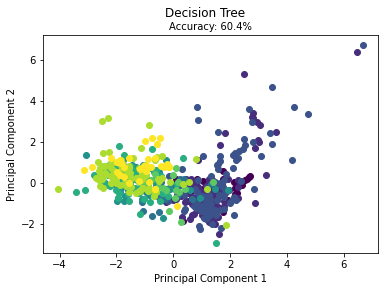

In [ ]:
from __future__ import division, print_function
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
import sys
import os

# Import helper functions
from utils import train_test_split, standardize, accuracy_score
from utils import mean_squared_error, calculate_variance, Plot
from decision_tree_model import ClassificationTree

def main():

    print ("-- Classification Tree --")

    X_train, X_test, y_train, y_test = train_test_split(
        scaled_features, correct_facies_labels, test_size=0.2)

    clf = ClassificationTree()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)

    print ("Accuracy:", accuracy)
    print(f'准确率：{accuracy:.2f}')

    Plot().plot_in_2d(X_test, y_pred,
        title="Decision Tree",
        accuracy=accuracy)


if __name__ == "__main__":
    main()

We need some metrics to evaluate how good our classifier is doing.  A [confusion matrix](http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/) is a table that can be used to describe the performance of a classification model.  [Scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) allows us to easily create a confusion matrix by supplying the actual and predicted facies labels.

The confusion matrix is simply a 2D array.  The entries of confusion matrix `C[i][j]` are equal to the number of observations predicted to have facies `j`, but are known to have facies `i`.  

To simplify reading the confusion matrix, a function has been written to display the matrix along with facies labels and various error metrics.  See the file `classification_utilities.py` in this repo for the `display_cm()` function.

我们需要一些指标来评估分类器的效果。 混淆矩阵是可用于描述分类模型性能的表。 Scikit-learn通过提供实际和预测的相貌标签，使我们能够轻松创建混淆矩阵。

混淆矩阵只是2D数组。 混淆矩阵C [i] [j]的条目等于预测具有相j的观测次数，但已知具有相i。

为了简化读取混淆矩阵，已编写了一个函数来显示矩阵以及相标和各种错误度量。 有关display_cm（）函数，请参见此存储库中的文件category_utilities.py。

这里需要导入一个py模块具体方法如下：

In [ ]:
#导入py模块
from google.colab import drive
drive.mount('/content/drive/')
#加入路径
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
from sklearn.metrics import confusion_matrix
from classification_utilities import display_cm, display_adj_cm
conf = confusion_matrix(y_test, predicted_labels)
display_cm(conf, facies_labels, hide_zeros=True)

NameError: ignored

The rows of the confusion matrix correspond to the actual facies labels.  The columns correspond to the labels assigned by the classifier.  For example, consider the first row. For the feature vectors in the test set that actually have label `SS`, 23 were correctly indentified as `SS`, 21 were classified as `CSiS` and 2 were classified as `FSiS`.

混淆矩阵的行对应于实际的相图。列对应于分类器分配的标签。例如，考虑第一行。对于实际存在标签SS的测试集中的特征向量，正确识别为SS的有23个，识别为CSiS的有21个，识别为FSiS的有2个。

The entries along the diagonal are the facies that have been correctly classified.  Below we define two functions that will give an overall value for how the algorithm is performing.  The accuracy is defined as the number of correct classifications divided by the total number of classifications.

沿对角线的条目是已正确分类的相。 在下面，我们定义了两个函数，它们将为算法的执行提供总体价值。 准确度定义为正确分类的数量除以分类的总数。

In [ ]:
def accuracy(conf):
    total_correct = 0.
    nb_classes = conf.shape[0]
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
    acc = total_correct/sum(sum(conf))
    return acc

As noted above, the boundaries between the facies classes are not all sharp, and some of them blend into one another.  The error within these 'adjacent facies' can also be calculated.  We define an array to represent the facies adjacent to each other.  For facies label `i`, `adjacent_facies[i]` is an array of the adjacent facies labels.

如上所述，各相类型之间的界限并不都很明显，其中一些相互融合。这些“相邻相”内的误差也可以计算出来。我们定义了一个数组来表示彼此相邻的相。对于相标志i，相邻相[i]是相邻相标志的数组。

In [ ]:
adjacent_facies = np.array([[1], [0,2], [1], [4], [3,5], [4,6,7], [5,7], [5,6,8], [6,7]])

def accuracy_adjacent(conf, adjacent_facies):
    nb_classes = conf.shape[0]
    total_correct = 0.
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
        for j in adjacent_facies[i]:
            total_correct += conf[i][j]
    return total_correct / sum(sum(conf))

In [ ]:
print('Facies classification accuracy = %f' % accuracy(conf))
print('Adjacent facies classification accuracy = %f' % accuracy_adjacent(conf, adjacent_facies))

## Model parameter selection

The classifier so far has been built with the default parameters.  However, we may be able to get improved classification results with optimal parameter choices.

到目前为止，分类器是使用默认参数构建的。然而，我们可能会得到改进的分类结果与最佳参数的选择。

We will consider two parameters.  The parameter `C` is a regularization factor, and tells the classifier how much we want to avoid misclassifying training examples.  A large value of C will try to correctly classify more examples from the training set, but if `C` is too large  it may 'overfit' the data and fail to generalize when classifying new data. If `C` is too small then the model will not be good at fitting outliers and will have a large error on the training set.

我们将考虑两个参数。 参数“ C”是一个正则化因子，它告诉分类器我们要避免对训练样本进行错误分类的程度。 较大的C值会尝试从训练集中正确分类更多示例，但是如果C值太大，则可能会“拟合”数据，并且在分类新数据时无法归纳。 如果C太小，则模型将无法很好地拟合离群值，并且训练集上的误差会很大。

The SVM learning algorithm uses a kernel function to compute the distance between feature vectors.  Many kernel functions exist, but in this case we are using the radial basis function `rbf` kernel (the default).  The `gamma` parameter describes the size of the radial basis functions, which is how far away two vectors in the feature space need to be to be considered close.

支持向量机学习算法利用核函数计算特征向量之间的距离。存在许多内核函数，但在本例中，我们使用径向基函数“rbf”内核(默认值)。参数描述径向基函数的大小，也就是特征空间中两个向量需要被认为是接近的距离。

We will train a series of classifiers with different values for `C` and `gamma`.  Two nested loops are used to train a classifier for every possible combination of values in the ranges specified.  The classification accuracy is recorded for each combination of parameter values.  The results are shown in a series of plots, so the parameter values that give the best classification accuracy on the test set can be selected.

我们将针对“ C”和“ gamma”训练一系列具有不同值的分类器。 两个嵌套循环用于为指定范围内值的每种可能组合训练分类器。 记录每个参数值组合的分类精度。 结果显示在一系列图中，因此可以选择在测试集上提供最佳分类精度的参数值。

This process is also known as 'cross validation'.  Often a separate 'cross validation' dataset will be created in addition to the training and test sets to do model selection.  For this tutorial we will just use the test set to choose model parameters.

这个过程也被称为“交叉验证”。通常，除了用于进行模型选择的培训和测试集之外，还会创建一个单独的“交叉验证”数据集。在本教程中，我们将使用测试集来选择模型参数。

In [ ]:
#model selection takes a few minutes, change this variable
#to true to run the parameter loop
do_model_selection = True

if do_model_selection:
    C_range = np.array([.01, 1, 5, 10, 20, 50, 100, 1000, 5000, 10000])
    gamma_range = np.array([0.0001, 0.001, 0.01, 0.1, 1, 10])
    
    fig, axes = plt.subplots(3, 2, 
                        sharex='col', sharey='row',figsize=(10,10))
    plot_number = 0
    for outer_ind, gamma_value in enumerate(gamma_range):
        row = int(plot_number / 2)
        column = int(plot_number % 2)
        cv_errors = np.zeros(C_range.shape)
        train_errors = np.zeros(C_range.shape)
        for index, c_value in enumerate(C_range):
            
            clf = svm.SVC(C=c_value, gamma=gamma_value)
            clf.fit(X_train,y_train)
            
            train_conf = confusion_matrix(y_train, clf.predict(X_train))
            cv_conf = confusion_matrix(y_test, clf.predict(X_test))
        
            cv_errors[index] = accuracy(cv_conf)
            train_errors[index] = accuracy(train_conf)

        ax = axes[row, column]
        ax.set_title('Gamma = %g'%gamma_value)
        ax.semilogx(C_range, cv_errors, label='CV error')
        ax.semilogx(C_range, train_errors, label='Train error')
        plot_number += 1
        ax.set_ylim([0.2,1])
        
    ax.legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0.)
    fig.text(0.5, 0.03, 'C value', ha='center',
             fontsize=14)
             
    fig.text(0.04, 0.5, 'Classification Accuracy', va='center', 
             rotation='vertical', fontsize=14)

The best accuracy on the cross validation error curve was achieved for `gamma = 1`, and `C = 10`.  We can now create and train an optimized classifier based on these parameters:

在gamma = 1和C = 10时，交叉验证误差曲线的精度最佳。现在，我们可以根据这些参数创建和训练一个优化的分类器

In [ ]:
clf = svm.SVC(C=10, gamma=1)        
clf.fit(X_train, y_train)

cv_conf = confusion_matrix(y_test, clf.predict(X_test))

print('Optimized facies classification accuracy = %.2f' % accuracy(cv_conf))

[Precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall) are metrics that give more insight into how the classifier performs for individual facies.  Precision is the probability that given a classification result for a sample, the sample actually belongs to that class.  Recall is the probability that a sample will be correctly classified for a given class.

Precision and recall can be computed easily using the confusion matrix.  The code to do so has been added to the `display_confusion_matrix()` function:

精度和回忆度是能够更深入地了解分类器对单个相的执行情况的指标。精度是给定一个样本的分类结果，这个样本实际上属于这个类别的概率。召回率是样本将被正确分类为给定类的概率。使用混淆矩阵可以很容易地计算出精确度和查全率。这样做的代码已经添加到display confusion matrix()函数中

In [ ]:
display_cm(cv_conf, facies_labels, 
           display_metrics=True, hide_zeros=True)

To interpret these results, consider facies `SS`.  In our test set, if a sample was labeled `SS` the probability the sample was correct is 0.8 (precision).  If we know a sample has facies `SS`, then the probability it will be correctly labeled by the classifier is 0.78 (recall).  It is desirable to have high values for both precision and recall, but often when an algorithm is tuned to increase one, the other decreases.  The [F1 score](https://en.wikipedia.org/wiki/Precision_and_recall#F-measure) combines both to give a single measure of relevancy of the classifier results.

These results can help guide intuition for how to improve the classifier results.  For example, for a sample with facies `MS` or mudstone, it is only classified correctly 57% of the time (recall).  Perhaps this could be improved by introducing more training samples.  Sample quality could also play a role.  Facies `BS` or bafflestone has the best `F1` score and relatively few training examples.  But this data was handpicked from other wells to provide training examples to identify this facies.

We can also consider the classification metrics when we consider misclassifying an adjacent facies as correct:

为了解释这些结果，考虑相SS。在我们的测试集中，如果一个样品被标记为SS，样品的正确概率是0.8(精度)。如果我们知道一个样品有相SS，那么它被分类器正确标记的概率是0.78 (recall)。我们希望具有较高的精度和回忆度值，但是通常当一个算法调优为增加一个时，另一个会减少。F1得分结合两者给一个单一的衡量分类器结果的相关性。

这些结果可以帮助指导如何改进分类器结果的直觉。 例如，对于具有相MS或泥岩相的样品，只有57％的时间正确分类（召回）。 也许可以通过引入更多的训练样本来改善这一点。 样品质量也可能起一定作用。 面相BS或Bafflestone具有最佳的F1分数，并且训练示例相对较少。 但是，这些数据是从其他井中挑选出来的，以提供训练实例来识别这种相。


In [ ]:
display_adj_cm(cv_conf, facies_labels, adjacent_facies, 
           display_metrics=True, hide_zeros=True)

Considering adjacent facies, the `F1` scores for all facies types are above 0.9, except when classifying `SiSh` or marine siltstone and shale.  The classifier often misclassifies this facies (recall of 0.66), most often as wackestone. 

These results are comparable to those reported in Dubois et al. (2007).

## Applying the classification model to the blind data

We held a well back from the training, and stored it in a dataframe called `blind`:

blind验证集

In [ ]:
blind

The label vector is just the `Facies` column:

In [ ]:
y_blind = blind['Facies'].values

We can form the feature matrix by dropping some of the columns and making a new dataframe:

In [ ]:
well_features = blind.drop(['Facies', 'Formation', 'Well Name', 'Depth'], axis=1)

Now we can transform this with the scaler we made before:

In [ ]:
X_blind = scaler.transform(well_features)

Now it's a simple matter of making a prediction and storing it back in the dataframe:

In [ ]:
y_pred = clf.predict(X_blind)
blind['Prediction'] = y_pred

Let's see how we did with the confusion matrix:

In [ ]:
cv_conf = confusion_matrix(y_blind, y_pred)

print('Optimized facies classification accuracy = %.2f' % accuracy(cv_conf))
print('Optimized adjacent facies classification accuracy = %.2f' % accuracy_adjacent(cv_conf, adjacent_facies))

We managed 0.75 using the test data, but it was from the same wells as the training data. This more reasonable test does not perform as well...

In [ ]:
display_cm(cv_conf, facies_labels,
           display_metrics=True, hide_zeros=True)

...but does remarkably well on the adjacent facies predictions. 

In [ ]:
display_adj_cm(cv_conf, facies_labels, adjacent_facies,
               display_metrics=True, hide_zeros=True)

In [ ]:
def compare_facies_plot(logs, compadre, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster1 = np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    cluster2 = np.repeat(np.expand_dims(logs[compadre].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=7, figsize=(9, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im1 = ax[5].imshow(cluster1, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    im2 = ax[6].imshow(cluster2, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[6])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im2, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-2):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    ax[6].set_xlabel(compadre)
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    ax[6].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

In [ ]:
compare_facies_plot(blind, 'Prediction', facies_colors)

## Applying the classification model to new data

Now that we have a trained facies classification model we can use it to identify facies in wells that do not have core data.  In this case, we will apply the classifier to two wells, but we could use it on any number of wells for which we have the same set of well logs for input.

This dataset is similar to the training data except it does not have facies labels.  It is loaded into a dataframe called `test_data`.

采用测试集

In [ ]:
well_data = pd.read_csv('/content/tutorials-2016/1610_Facies_classification/validation_data_nofacies.csv')
well_data['Well Name'] = well_data['Well Name'].astype('category')
well_features = well_data.drop(['Formation', 'Well Name', 'Depth'], axis=1)

The data needs to be scaled using the same constants we used for the training data.

In [ ]:
X_unknown = scaler.transform(well_features)

Finally we predict facies labels for the unknown data, and store the results in a `Facies` column of the `test_data` dataframe.

In [ ]:
#predict facies of unclassified data
y_unknown = clf.predict(X_unknown)
well_data['Facies'] = y_unknown
well_data
#把预测的结果放到最后

In [ ]:
well_data['Well Name'].unique()

We can use the well log plot to view the classification results along with the well logs.

In [ ]:
make_facies_log_plot(
    well_data[well_data['Well Name'] == 'STUART'],
    facies_colors=facies_colors)

make_facies_log_plot(
    well_data[well_data['Well Name'] == 'CRAWFORD'],
    facies_colors=facies_colors)

Finally we can write out a csv file with the well data along with the facies classification results.

In [ ]:
well_data.to_csv('/content/drive/My Drive/Android/结果.csv')

## References

Amato del Monte, A., 2015. Seismic Petrophysics: Part 1, *The Leading Edge*, 34 (4). [doi:10.1190/tle34040440.1](http://dx.doi.org/10.1190/tle34040440.1)

Bohling, G. C., and M. K. Dubois, 2003. An Integrated Application of Neural Network and Markov Chain Techniques to Prediction of Lithofacies from Well Logs, *KGS Open-File Report* 2003-50, 6 pp. [pdf](http://www.kgs.ku.edu/PRS/publication/2003/ofr2003-50.pdf)

Dubois, M. K., G. C. Bohling, and S. Chakrabarti, 2007, Comparison of four approaches to a rock facies classification problem, *Computers & Geosciences*, 33 (5), 599-617 pp. [doi:10.1016/j.cageo.2006.08.011](http://dx.doi.org/10.1016/j.cageo.2006.08.011)